In [ ]:
import os
os.environ['TF_CP_MIN_LOG_LEVEL'] = '2'
import sys
import numpy as np

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
my_drive = '/content/drive/MyDrive'

## pYTB21 primer extension with BrdUTP, dATP, dCTP, dGTP
brdu_dir = os.path.join(my_drive, "5-mer_data/BTF_G_ONT_1_FAD19641_BrdU_5mer")
pYTB21_brdu_file_name = os.path.join(brdu_dir, '5mer.pYTB.BTF_G_ONT_1_FAD19641_BrdU.brdu.perc.pkl')

with open(pYTB21_brdu_file_name, 'rb') as brdu_f:
  brdu_perc_pYTB_BrdU = pickle.load(brdu_f)
  brdu_perc_pYTB_BrdU = pd.DataFrame.from_dict(brdu_perc_pYTB_BrdU, orient='index')
  brdu_perc_pYTB_BrdU.columns = ['perc']

  # reads with BrdU% > 12.5% are considered as positive reads
  positive = brdu_perc_pYTB_BrdU[brdu_perc_pYTB_BrdU['perc'] > 0.125]
  print(len(positive))
positive_reads = positive.index.to_list()
print(len(positive_reads))
print(positive_reads[0:10])

1732
1732
['I0013773_20160809_FNFAD19641_MN17490_sequencing_run_BTF_G_test416_160809_37764_ch52_read33_strand.fast5.resquiggle.features.txt.pkl', 'I0013773_20160809_FNFAD19641_MN17490_sequencing_run_BTF_G_test416_160809_37764_ch372_read15405_strand.fast5.resquiggle.features.txt.pkl', 'I0013773_20160809_FNFAD19641_MN17490_sequencing_run_BTF_G_test416_160809_37764_ch445_read2342_strand.fast5.resquiggle.features.txt.pkl', 'I0013773_20160809_FNFAD19641_MN17490_sequencing_run_BTF_G_test416_160809_37764_ch52_read337_strand.fast5.resquiggle.features.txt.pkl', 'I0013773_20160809_FNFAD19641_MN17490_sequencing_run_BTF_G_test416_160809_37764_ch372_read15693_strand.fast5.resquiggle.features.txt.pkl', 'I0013773_20160809_FNFAD19641_MN17490_sequencing_run_BTF_G_test416_160809_37764_ch445_read2415_strand.fast5.resquiggle.features.txt.pkl', 'I0013773_20160809_FNFAD19641_MN17490_sequencing_run_BTF_G_test416_160809_37764_ch52_read338_strand.fast5.resquiggle.features.txt.pkl', 'I0013773_20160809_FNFAD1964

In [ ]:
def combine_pickled_arrays(file_paths, output_path):
    """
    Combines NumPy arrays from multiple pickled files into a single array.

    Args:
        file_paths (list): A list of file paths to the pickled arrays.
        output_path (str): The file path to save the combined array.
    """
    arrays = []
    for file_path in file_paths:
        if os.path.exists(file_path):
            try:
                arr = np.load(file_path, allow_pickle=True)
                arrays.append(arr)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")

    if arrays:
        combined_array = np.concatenate(arrays, axis=0)
        np.save(output_path, combined_array)
        print(f"Combined array saved to {output_path}")
        return combined_array
    else:
        print("No arrays were loaded. Combined array not saved.")

In [ ]:
out_dir = '/content/drive/MyDrive/5-mer_data'
brdu_dir = os.path.join(out_dir, "BTF_G_ONT_1_FAD19641_BrdU_5mer")
file_paths = [os.path.join(brdu_dir, file_name) for file_name in positive_reads]

output_path = os.path.join(out_dir, "pYTB.5mer.100.brdu.combined_array.npy")
pYTB_brdu_X = combine_pickled_arrays(file_paths, output_path)

Combined array saved to /content/drive/MyDrive/5-mer_data/pYTB.5mer.100.brdu.combined_array.npy


In [ ]:
pYTB_brdu_X = np.load(os.path.join(out_dir, "pYTB.5mer.100.brdu.combined_array.npy"))
out_dir = '/content/drive/MyDrive/5-mer_data'
#generate labels for  5mers, which are BrdU always
pYTB_brdu_y = np.full((pYTB_brdu_X.shape[0], 1), "B")

# convert dummies using the universe ["A", "B" "C", "G", "T"]
aplhabets = np.array(["A", "B", "C", "G", "T"]).reshape(5, 1)

pYTB_brdu_y_p = np.vstack((aplhabets, pYTB_brdu_y), dtype=object)
pYTB_brdu_label = pd.get_dummies(pYTB_brdu_y_p.ravel(), dtype=float).values

# remove the first 5 rows
pYTB_brdu_label = pYTB_brdu_label[5:, :]
print(pYTB_brdu_label.shape)
print(pYTB_brdu_label)

## save _y label
np.save(os.path.join(out_dir,"pYTB.5mer.100.brdu.label.npy"), pYTB_brdu_label)

(2458700, 5)
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [ ]:
# use mouse BrdU-free data as negative data after removing some potential contamination (reads from human
# HK293 cells cultured in BrdU-supplemented media, two DNA samples were indexed and sequenced together in
# the same flow cells.)
mouse_5mer_dir = "/content/drive/MyDrive/5-mer_data/"
mouse_5mer_brdu_perc_file = os.path.join(mouse_5mer_dir , "5mer.mouse.brdu-free.perc.pkl")

with open(mouse_5mer_brdu_perc_file , 'rb') as perc_f:
  brdu_perc_mouse = pickle.load(perc_f)

  brdu_perc_mouse = pd.DataFrame.from_dict(brdu_perc_mouse, orient='index')
  brdu_perc_mouse.columns = ['perc']

  # reads with BrdU% < 7.5% are considered as negative reads
  negative = brdu_perc_mouse[brdu_perc_mouse['perc'] < 0.075]
negative_reads = negative.index.to_list()
print(negative_reads[:5])

['ee283b82-24da-4279-bc7f-556f1cd55796.fast5.resquiggle.features.txt.pkl', 'ee298f05-8efc-46cd-a5dc-2e83a73626a8.fast5.resquiggle.features.txt.pkl', 'a24605b6-5e79-4ac0-a9f6-bba203b94667.fast5.resquiggle.features.txt.pkl', 'c6f803d7-5610-4735-8fdb-eb7a38380883.fast5.resquiggle.features.txt.pkl', 'ee2f9a92-89a2-4bac-881b-09fbeb9e2456.fast5.resquiggle.features.txt.pkl']


In [ ]:
print(len(negative_reads))

3018


In [ ]:
out_dir = '/content/drive/MyDrive/5-mer_data'
mouse_5mer_dir = "/content/drive/MyDrive/5-mer_data/barcode01"
file_paths = [os.path.join(mouse_5mer_dir, f) for f in os.listdir(mouse_5mer_dir) if f in negative_reads]
print(len(file_paths))
output_path = os.path.join(out_dir, "5mer.mouse.brdu-free.combined_array.npy")
mouse_t_X = combine_pickled_arrays(file_paths, output_path)
print(mouse_t_X.shape)

In [ ]:
out_dir = '/content/drive/MyDrive/5-mer_data'
pYTB_brdu_X = np.load(os.path.join(out_dir, "pYTB.5mer.100.brdu.combined_array.npy"))
pYTB_brdu_y = np.load(os.path.join(out_dir, "pYTB.5mer.100.brdu.label.npy"))
mouse_t_X = np.load(os.path.join(out_dir, "5mer.mouse.brdu-free.combined_array.npy"))


In [ ]:
print(pYTB_brdu_X.shape)
print(pYTB_brdu_y.shape)
print(mouse_t_X.shape)

(2458700, 5, 7)
(2458700, 5)
(8019163, 5, 7)


In [ ]:
#generate labels for  5mers, which are BrdU always
mouse_t_y = np.full((mouse_t_X.shape[0], 1), "T")

# convert dummies using the universe ["A", "B" "C", "G", "T"]
aplhabets = np.array(["A", "B", "C", "G", "T"]).reshape(5, 1)

mouse_t_y_p = np.vstack((aplhabets, mouse_t_y), dtype=object)

mouse_t_y = pd.get_dummies(mouse_t_y_p.ravel(), dtype=float).values

# remove the first 5 rows
mouse_t_label = mouse_t_y[5:, :]
print(mouse_t_label.shape)

## save label
np.save(os.path.join(out_dir,"5mer.mouse.brdu-free.label.npy"), mouse_t_label)

(8019163, 5)


In [ ]:
## shuffle and select
mouse_t_X, mouse_t_label = shuffle(mouse_t_X, mouse_t_label, random_state= 42 )
mouse_t_X_select = mouse_t_X[:pYTB_brdu_X.shape[0]]
mouse_t_label_select = mouse_t_label[:pYTB_brdu_X.shape[0]]

In [ ]:
X = np.concatenate((pYTB_brdu_X, mouse_t_X_select), axis=0)
y = np.concatenate((pYTB_brdu_y, mouse_t_label_select), axis=0)
print(X.shape)
print(y.shape)

(4917400, 5, 7)
(4917400, 5)


In [ ]:
X, y = shuffle(X, y, random_state= 42 )

# split _x and _y for training_tmp (90%) and testing (10%)
X_train_tmp, X_test, y_train_tmp, y_test = \
         train_test_split(X, y, test_size=0.1, random_state=42)

# split _x and _y for training (80%) and validation (10%)
X_train, X_val, y_train, y_val = \
         train_test_split(X_train_tmp, y_train_tmp,
                          test_size=0.11, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(3938837, 5, 7)
(3938837, 5)
(486823, 5, 7)
(486823, 5)
(491740, 5, 7)
(491740, 5)


In [ ]:
## use sythetic data 5-mers
syn_dir = '/content/drive/MyDrive/5-mer_data'

with open(f'{syn_dir}/009.2.5mer.feature.pkl', 'rb') as file:
  syn_X = pickle.load(file)
with open(f'{syn_dir}/009.1.mid.position.base.array.pkl', 'rb') as file:
  syn_y = pickle.load(file)

syn_X, syn_y = shuffle(syn_X, syn_y, random_state= 42 )

# split _x and _y for training_tmp (90%) and testing (10%)
syn_X_train_tmp, syn_X_test, syn_y_train_tmp, syn_y_test = \
         train_test_split(syn_X, syn_y, test_size=0.1, random_state=42)

# split _x and _y for training (80%) and validation (10%)
syn_X_train, syn_X_val, syn_y_train, syn_y_val = \
         train_test_split(syn_X_train_tmp, syn_y_train_tmp,
                          test_size=0.11, random_state=42)


In [ ]:
X_train = np.concatenate((X_train, syn_X_train), axis=0)
y_train = np.concatenate((y_train, syn_y_train), axis=0)
X_val = np.concatenate((X_val, syn_X_val), axis=0)
y_val = np.concatenate((y_val, syn_y_val), axis=0)
X_test = np.concatenate((X_test, syn_X_test), axis=0)
y_test = np.concatenate((y_test, syn_y_test), axis=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4111024, 5, 7)
(4111024, 5)
(508105, 5, 7)
(508105, 5)
(513237, 5, 7)
(513237, 5)


In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state= 42)
X_val, y_val = shuffle(X_val, y_val, random_state= 42)
X_test, y_test = shuffle(X_test, y_test, random_state= 42)

In [ ]:
from sklearn.utils import class_weight

y_train_labels= np.where(y_train==1)[1]
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: np.float64(18.400017903099474), 1: np.float64(0.41274367522453037), 2: np.float64(18.858340787632745), 3: np.float64(25.097060529287873), 4: np.float64(0.4115279198691447)}


In [ ]:
model = keras.Sequential([
    # tf.keras.Input()-- instantiate a Keras tensor
    # In TensorFlow Keras, input layers are essential for defining the expected
    # shape and data type of input data for a neural network. There are two primary
    #  ways to define input layers: keras.Input and keras.layers.InputLayer.
    # --keras.Input: This approach is often favored for its conciseness and flexibility,
    #  especially when building models using the Functional API. It directly creates a
    # symbolic tensor-like object representing the input.
    # Define an input layer for a sequence of 5 time steps with 7 features each
    # None for batch size
    keras.Input(shape = (7,7), dtype = "float32"),
    layers.Bidirectional(layers.GRU(units=128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(units=128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(units=128)),
    layers.Dense(units = 5, activation='softmax')
])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 256)         │       105,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 7, 256)         │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,397 (2.67 MB)

 Trainable params: 699,397 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0002),
              # If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss
              # from_logits in keras.losses.CategoricalCrossentropy should be set to True when the
              # output of your model's last layer has not passed through a softmax
              # activation function.
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction='sum_over_batch_size',
                    name='categorical_crossentropy'
                  ),
              loss_weights = None,
              metrics=['categorical_accuracy', 'precision', 'recall',
                       keras.metrics.AUC(name='prc', curve='PR')])

In [ ]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(X_train, y_train,
          validation_data = (X_val, y_val),
          batch_size = 128,
          # An epoch in Machine Learning, is the entire processing
          # by the learning algorithm of the entire train-set.
          epochs = 30,
          class_weight = class_weights_dict,
          callbacks = [early_stopping],
          verbose = 2)

Epoch 1/30
32118/32118 - 359s - 11ms/step - categorical_accuracy: 0.8590 - loss: 0.1797 - prc: 0.9361 - precision: 0.8659 - recall: 0.8523 - val_categorical_accuracy: 0.9024 - val_loss: 0.2427 - val_prc: 0.9647 - val_precision: 0.9029 - val_recall: 0.9017
Epoch 2/30
32118/32118 - 352s - 11ms/step - categorical_accuracy: 0.9137 - loss: 0.1088 - prc: 0.9712 - precision: 0.9146 - recall: 0.9125 - val_categorical_accuracy: 0.9216 - val_loss: 0.1997 - val_prc: 0.9757 - val_precision: 0.9220 - val_recall: 0.9209
Epoch 3/30
32118/32118 - 353s - 11ms/step - categorical_accuracy: 0.9267 - loss: 0.0935 - prc: 0.9784 - precision: 0.9276 - recall: 0.9257 - val_categorical_accuracy: 0.9302 - val_loss: 0.1820 - val_prc: 0.9798 - val_precision: 0.9310 - val_recall: 0.9291
Epoch 4/30
32118/32118 - 349s - 11ms/step - categorical_accuracy: 0.9328 - loss: 0.0846 - prc: 0.9815 - precision: 0.9335 - recall: 0.9319 - val_categorical_accuracy: 0.9327 - val_loss: 0.1754 - val_prc: 0.9810 - val_precision: 0.93

In [ ]:
model.save('/content/drive/MyDrive/005.BrdU.basecaller.model.trained.w.pYTB.synthetic.mouse.5mer-20250711-1053.keras')

In [ ]:
#load model
model = tf.keras.models.load_model('/content/drive/MyDrive/005.BrdU.basecaller.model.trained.w.pYTB.synthetic.mouse.5mer-20250711-1053.keras')

In [ ]:
## plot accuracy curve
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/5-mer_data/Figure003.pYTB21.Syn.brdu.mouse.5mer.model.accuracy.pdf')
plt.show()

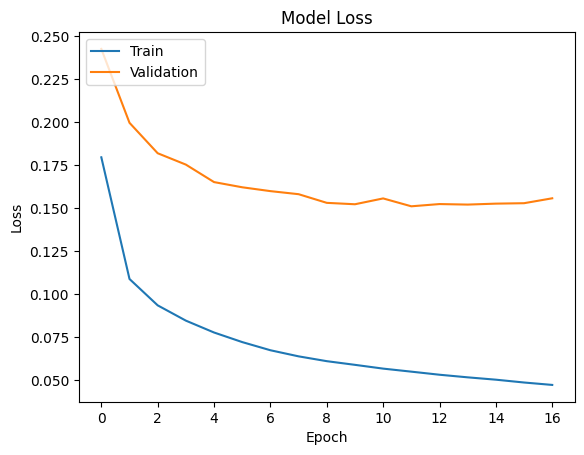

In [ ]:
## plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
## confusion matrix mouse_x, mouse_x, mouse_label
labels= np.where(y_test ==1)[1]
predictions = model.predict(X_test)

16039/16039 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step


In [ ]:
def softmax_to_label(softmax_output):
  """Converts softmax probabilities to a label encoded value.

  Args:
    softmax_output: A list or numpy array of probabilities.

  Returns:
    The index of the highest probability.
  """
  return np.argmax(softmax_output)

In [ ]:
predictions_label = np.apply_along_axis(softmax_to_label,  1, predictions)
print(len(predictions_label))
confusion_matrix = tf.math.confusion_matrix(labels,
                                           predictions_label,
                                           num_classes=5)

# Print the confusion matrix
print(confusion_matrix.numpy())

513237
[[  5542      9     10      4      4]
 [     8 234043     30     10  14661]
 [     4      7   5388      7      6]
 [    11      4     14   4034      9]
 [    14  14563     34     13 234808]]


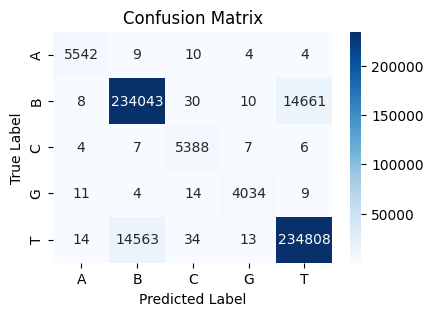

In [ ]:
class_names = ["A","B", "C", "G", "T"]
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(4.5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('/content/drive/MyDrive/5-mer_data/Figure003.pYTB21.Syn.brdu.mouse.5mer.confusion_matrix.pdf')
    plt.show()


plot_confusion_matrix(confusion_matrix.numpy(), class_names)

In [ ]:
model.evaluate(X_test, y_test,
               batch_size = 128,
               verbose = 2)

4010/4010 - 19s - 5ms/step - categorical_accuracy: 0.9427 - loss: 0.1511 - prc: 0.9852 - precision: 0.9428 - recall: 0.9426


[0.15105724334716797,
 0.9426736831665039,
 0.9427778124809265,
 0.9425995945930481,
 0.9851735830307007]

In [ ]:
pickle_files = os.listdir('/content/drive/MyDrive/5-mer_data/barcode01')

mouse_perc = {}
for p in pickle_files:
  with open(f'/content/drive/MyDrive/5-mer_data/barcode01/{p}', 'rb') as file:
    X_test = pickle.load(file)
    predictions = model.predict(X_test, verbose=0)

    predictions_labels = np.apply_along_axis(softmax_to_label,  1, predictions)
    BrdU_percentage = np.sum(predictions_labels==1)/len(predictions_labels)
    #print(f"{p} : {BrdU_percentage}")
    mouse_perc[p] = BrdU_percentage

In [ ]:
with open(os.path.join('/content/drive/MyDrive/5-mer_data',
                       '5mer.mouse.brdu-free.perc-pYTB.syn.mouse-20250711.pkl'), 'wb') as file:
  pickle.dump(mouse_perc, file)

In [ ]:
pickle_files = os.listdir('/content/drive/MyDrive/5-mer_data/barcode02')

human_perc = {}
for p in pickle_files:
  with open(f'/content/drive/MyDrive/5-mer_data/barcode02/{p}', 'rb') as file:
    X_test = pickle.load(file)
    predictions = model.predict(X_test, verbose=0)

    predictions_labels = np.apply_along_axis(softmax_to_label,  1, predictions)
    BrdU_percentage = np.sum(predictions_labels==1)/len(predictions_labels)
    #print(f"{p} : {BrdU_percentage}")
    human_perc[p] = BrdU_percentage
with open(os.path.join('/content/drive/MyDrive/5-mer_data',
                       '5mer.human.brdu-free.perc-pYTB.syn.mouse-20250711.pkl'), 'wb') as file:
  pickle.dump(human_perc, file)


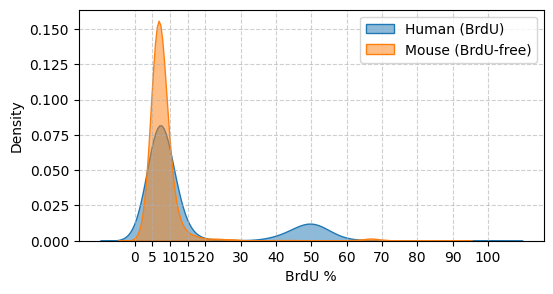

In [ ]:
with open(os.path.join('/content/drive/MyDrive/5-mer_data',
                       '5mer.mouse.brdu-free.perc-pYTB.syn.mouse.pkl'), 'rb') as file:
  mouse_perc = pickle.load(file)

with open(os.path.join('/content/drive/MyDrive/5-mer_data',
                       '5mer.human.brdu-free.perc-pYTB.syn.mouse.pkl'), 'rb') as file:
  human_perc = pickle.load(file)
human_perc = pd.DataFrame.from_dict(human_perc, orient='index')
human_perc.columns = ['perc']
mouse_perc = pd.DataFrame.from_dict(mouse_perc, orient='index')
mouse_perc.columns = ['perc']

# Density plot showing the human HEK293 BrdU% per read
plt.figure(figsize=(6, 3))
plt.tight_layout()
sns.kdeplot(human_perc['perc']*100, label='Human (BrdU)', fill=True, alpha=0.5)

# Density plot showing the mouse 3T3 BrdU% per read
sns.kdeplot(mouse_perc['perc']*100, label='Mouse (BrdU-free)', fill=True, alpha=0.5)

# Add labels and title
plt.xlabel('BrdU %')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
# reset x-axis ticks
plt.xticks(np.array([0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]))

plt.savefig('/content/drive/MyDrive/5-mer_data/Figure003.pYTB21.Syn.brdu.mouse.5mer.predict.brdu.perc.pdf', bbox_inches = 'tight')
# Show the plot
plt.show()

In [ ]:
#load model
model = tf.keras.models.load_model('/content/drive/MyDrive/002.BrdU.basecaller.model.trained.w.pYTB.synthetic.mouse.7mer-20250704-1509.keras')


In [ ]:
in_dir = '/content/drive/MyDrive/5-mer_data/BO_testing_1_5mer'
pickle_files = os.listdir(in_dir)[:100]

yeast_00_perc = {}
for p in pickle_files:
  with open(f'{in_dir}/{p}', 'rb') as file:
    X_test = pickle.load(file)
    predictions = model.predict(X_test, verbose=0)

    predictions_labels = np.apply_along_axis(softmax_to_label,  1, predictions)
    BrdU_percentage = np.sum(predictions_labels==1)/len(predictions_labels)
    #print(f"{p} : {BrdU_percentage}")
    yeast_00_perc[p] = BrdU_percentage

In [ ]:
in_dir = '/content/drive/MyDrive/5-mer_data/BY_testing_1_5mer'
pickle_files = os.listdir(in_dir)[:100]

yeast_100_perc = {}
for p in pickle_files:
  with open(f'{in_dir}/{p}', 'rb') as file:
    X_test = pickle.load(file)
    predictions = model.predict(X_test, verbose=0)

    predictions_labels = np.apply_along_axis(softmax_to_label,  1, predictions)
    BrdU_percentage = np.sum(predictions_labels==1)/len(predictions_labels)
    #print(f"{p} : {BrdU_percentage}")
    yeast_100_perc[p] = BrdU_percentage

In [ ]:
with open(os.path.join('/content/drive/MyDrive/5-mer_data',
                       'BY_testing_1_5mer.BrdU.content.per.read-20250711.pkl'), 'wb') as file:
  pickle.dump(yeast_100_perc, file)

#with open(os.path.join('/content/drive/MyDrive/5-mer_data',
#                       'BO_testing_1_5mer.BrdU.content.per.read-20250711.pkl'), 'wb') as file:
#  pickle.dump(yeast_00_perc, file)

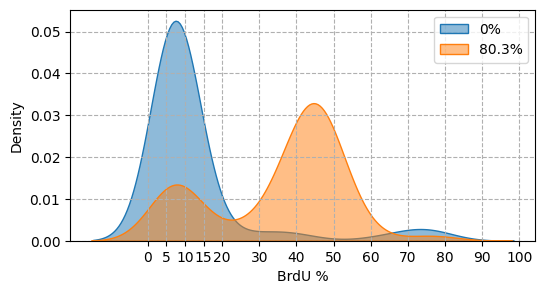

In [ ]:
with open(os.path.join('/content/drive/MyDrive/5-mer_data',
                       'BY_testing_1_5mer.BrdU.content.per.read-20250711.pkl'), 'rb') as file:
  yeast_100_perc = pickle.load(file)

with open(os.path.join('/content/drive/MyDrive/5-mer_data',
                       'BO_testing_1_5mer.BrdU.content.per.read-20250711.pkl'), 'rb') as file:
  yeast_00_perc = pickle.load(file)



yeast_00_perc1 = pd.DataFrame.from_dict(yeast_00_perc, orient='index')
yeast_00_perc1.columns = ['perc']
yeast_100_perc5 = pd.DataFrame.from_dict(yeast_100_perc, orient='index')
yeast_100_perc5.columns = ['perc']

# Density plot
plt.figure(figsize=(6, 3))
plt.tight_layout()

sns.kdeplot(yeast_00_perc1['perc']*100, label='0%', fill=True, alpha=0.5)
sns.kdeplot(yeast_100_perc5['perc']*100, label='80.3%', fill=True, alpha=0.5)
# Add labels and title
plt.xlabel('BrdU %')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=1)
# reset x-axis ticks
plt.xticks(np.array([0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]))
plt.savefig('/content/drive/MyDrive/5-mer_data/Figure003.pYTB21.Syn.brdu.mouse.5mer.predict.yeast.brdu.perc.pdf', bbox_inches = 'tight')

# Show the plot
plt.show()

In [ ]:
# implement a 3-layer, bidirectional RNN autoencoder




